# Model Tuning: Grid Search + Pipeline

In [27]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats as stats

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree

from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import train_test_split, GridSearchCV,\
cross_val_score, RandomizedSearchCV

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Objectives

- Explain what hyperparameters are
- Describe the purpose of grid searching
- Implement grid searching for the purposes of model optimization.

# Model Tuning

![](https://imgs.xkcd.com/comics/machine_learning.png)

## Hyperparameters

Many of the models we have looked at are really *families* of models in the sense that they make use of **hyperparameters**.

Thus for example the $k$-nearest-neighbors algorithm allows us to make:

- a 1-nearest-neighbor model
- a 2-nearest-neighbors model
- a 3-nearest-neighbors model
- etc.

Or, for another example, the decision tree algorithm allows us to make:

- a classifier that branches according to information gain
- a classifier that branches according to Gini impurity
- a regressor that branches according to mean squared error
- etc.

Depending on the sort of problem and data at hand, it is natural to experiment with different values of these hyperparameters to try to improve model performance.

> We can think of these **hyperparameters** as _dials_ of the base model

<img width=60% src='images/dials.png'/>

### Difference from Parametric / Non-Parametric Models

Contrast the notion of hyperparameters with the distinction between parametric and non-parametric models.

A linear regression model is parametric in the sense that we start with a given model *form* and we then search for the optimal parameters to fill in that form. But *those* parameters are not the sort we might tweak for the purposes of improving model performance. On the contrary, there is one best set of parameters, and the training of the model is a matter of finding those optimal values.

## Data Example

![Penguins](https://raw.githubusercontent.com/allisonhorst/palmerpenguins/69530276d74b99df81cc385f4e95c644da69ebfa/man/figures/lter_penguins.png)

> Images source: @allison_horst [github.com/allisonhorst/penguins](github.com/allisonhorst/penguins)

In [2]:
penguins = sns.load_dataset('penguins')

![Bill length & depth](https://raw.githubusercontent.com/allisonhorst/palmerpenguins/69530276d74b99df81cc385f4e95c644da69ebfa/man/figures/culmen_depth.png)

> Images source: @allison_horst [github.com/allisonhorst/penguins](github.com/allisonhorst/penguins)

In [3]:
penguins.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female


In [4]:
penguins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   bill_length_mm     342 non-null    float64
 3   bill_depth_mm      342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                333 non-null    object 
dtypes: float64(4), object(3)
memory usage: 18.9+ KB


In [5]:
penguins.describe()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
count,342.000000,342.000000,342.000000,342.000000
mean,43.921930,17.151170,200.915205,4201.754386
std,5.459584,1.974793,14.061714,801.954536
min,32.100000,13.100000,172.000000,2700.000000
25%,39.225000,15.600000,190.000000,3550.000000
50%,44.450000,17.300000,197.000000,4050.000000
75%,48.500000,18.700000,213.000000,4750.000000
max,59.600000,21.500000,231.000000,6300.000000


### Data Prep

We'll try to predict species given the other columns' values. Let's dummy-out `island` and `sex`:

In [6]:
penguins.isna().sum().sum()

19

In [7]:
penguins = penguins.dropna()

In [8]:
y = penguins.pop('species')
y

0      Adelie
1      Adelie
2      Adelie
4      Adelie
5      Adelie
        ...  
338    Gentoo
340    Gentoo
341    Gentoo
342    Gentoo
343    Gentoo
Name: species, Length: 333, dtype: object

In [9]:
penguins

,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Torgersen,40.3,18.0,195.0,3250.0,Female
4,Torgersen,36.7,19.3,193.0,3450.0,Female
5,Torgersen,39.3,20.6,190.0,3650.0,Male
...,...,...,...,...,...,...
338,Biscoe,47.2,13.7,214.0,4925.0,Female
340,Biscoe,46.8,14.3,215.0,4850.0,Female
341,Biscoe,50.4,15.7,222.0,5750.0,Male
342,Biscoe,45.2,14.8,212.0,5200.0,Female


In [10]:
# Note we're dedicating a lot of data to the testing set just for demonstrative purposes
X_train, X_test, y_train, y_test = train_test_split(
    penguins, y, test_size=0.5, random_state=42)

In [11]:
X_train_cat = X_train.select_dtypes('object')

ohe = OneHotEncoder(sparse=False)

dums = ohe.fit_transform(X_train_cat)
dums_df = pd.DataFrame(dums,
                       columns=ohe.get_feature_names(),
                       index=X_train_cat.index)

In [12]:
dums_df.head()

,x0_Biscoe,x0_Dream,x0_Torgersen,x1_Female,x1_Male
160,0.0,1.0,0.0,1.0,0.0
237,1.0,0.0,0.0,0.0,1.0
2,0.0,0.0,1.0,1.0,0.0
121,0.0,0.0,1.0,0.0,1.0
179,0.0,1.0,0.0,0.0,1.0


In [13]:
X_train_nums = X_train.select_dtypes('float64')

ss = StandardScaler()

ss.fit(X_train_nums)
nums_df = pd.DataFrame(ss.transform(X_train_nums),
                      index=X_train_nums.index)
nums_df

,0,1,2,3
160,0.362748,0.903276,-0.472344,-0.094599
237,0.973499,-0.977375,1.408317,2.512546
2,-0.725152,0.445820,-0.472344,-1.185963
121,-1.221387,1.360731,-0.255345,-0.882806
179,1.030757,0.954104,-0.110678,-0.519018
...,...,...,...,...
194,1.297960,1.004932,-0.400011,-0.822175
77,-1.316816,1.157417,-1.268008,-0.397756
112,-0.839667,0.293335,-0.617010,-1.246594
277,0.267318,-1.079032,1.335984,0.936132


In [14]:
X_train_clean = pd.concat([nums_df, dums_df], axis=1)

In [15]:
X_train_clean.head()

,0,1,2,3,x0_Biscoe,x0_Dream,x0_Torgersen,x1_Female,x1_Male
160,0.362748,0.903276,-0.472344,-0.094599,0.0,1.0,0.0,1.0,0.0
237,0.973499,-0.977375,1.408317,2.512546,1.0,0.0,0.0,0.0,1.0
2,-0.725152,0.445820,-0.472344,-1.185963,0.0,0.0,1.0,1.0,0.0
121,-1.221387,1.360731,-0.255345,-0.882806,0.0,0.0,1.0,0.0,1.0
179,1.030757,0.954104,-0.110678,-0.519018,0.0,1.0,0.0,0.0,1.0


#### Preparing the Test Set

In [16]:
X_test_cat = X_test.select_dtypes('object')

test_dums = ohe.transform(X_test_cat)
test_dums_df = pd.DataFrame(test_dums,
                       columns=ohe.get_feature_names(),
                      index=X_test_cat.index)

In [17]:
X_test_nums = X_test.select_dtypes('float64')

test_nums = ss.transform(X_test_nums)
test_nums_df = pd.DataFrame(test_nums,
                           index=X_test_nums.index)

In [18]:
X_test_clean = pd.concat([test_nums_df,
                 test_dums_df], axis=1)

In [19]:
X_test_clean.head()

,0,1,2,3,x0_Biscoe,x0_Dream,x0_Torgersen,x1_Female,x1_Male
30,-0.877839,-0.214949,-1.702007,-1.185963,0.0,1.0,0.0,1.0,0.0
317,0.534522,-1.282345,1.480650,0.784554,1.0,0.0,0.0,1.0,0.0
79,-0.381604,1.004932,-0.472344,-0.276493,0.0,0.0,1.0,0.0,1.0
201,1.088015,0.090021,-0.255345,-0.670597,0.0,1.0,0.0,1.0,0.0
63,-0.572464,0.547477,-0.689343,-0.215862,1.0,0.0,0.0,0.0,1.0


### Trying Different Models & Values

#### Decision Tree

In [20]:
dt = DecisionTreeClassifier(random_state=10)

dt.fit(X_train_clean, y_train)

DecisionTreeClassifier(random_state=10)

In [21]:
dt.score(X_train_clean, y_train)

1.0

In [22]:
dt.score(X_test_clean, y_test)

0.9700598802395209

##### Changing the branching criterion

In [23]:
dt2 = DecisionTreeClassifier(criterion='entropy',
                          random_state=10)

dt2.fit(X_train_clean, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=10)

In [26]:
dt2.score(X_train_clean, y_train)

1.0

In [25]:
dt2.score(X_test_clean, y_test)

0.9700598802395209

##### Changing the max_depth

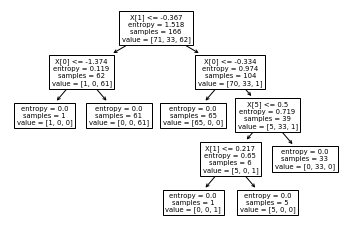

In [29]:
plot_tree(dt2);

In [31]:
dt2.get_depth()

4

In [48]:
# How much tho?
dt3 = DecisionTreeClassifier(max_depth=3, criterion='entropy',
                          random_state=10)

dt3.fit(X_train_clean, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=10)

In [49]:
dt3.score(X_train_clean, y_train)

0.9939759036144579

In [50]:
dt3.score(X_test_clean, y_test)

0.9281437125748503

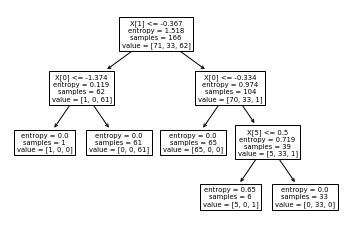

In [51]:
plot_tree(dt3);

In [62]:
dt4 = DecisionTreeClassifier(min_samples_split=7, criterion='entropy',
                          random_state=10)

dt4.fit(X_train_clean, y_train)

DecisionTreeClassifier(criterion='entropy', min_samples_split=7,
                       random_state=10)

In [63]:
dt4.score(X_train_clean, y_train)

0.9939759036144579

In [64]:
dt4.score(X_test_clean, y_test)

0.9281437125748503

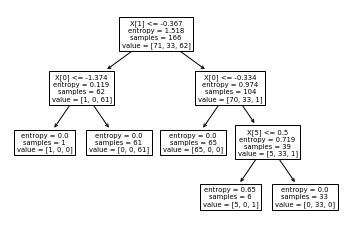

In [65]:
plot_tree(dt4);

# Automatically Searching with Grid Search

It's not a bad idea to experiment with the values of your models' hyperparameters a bit as you're getting a feel for your models' performance. But there are more systematic ways of going about the search for optimal hyperparameters. One method of hyperparameter tuning is **grid searching**. 

The idea is to build multiple models with different hyperparameter values and then see which one performs the best. The hyperparameters and the values to try form a sort of *grid* along which we are looking for the best performance. For example:


    1           | 'minkowski' | 'uniform'
    3           | 'manhattan' | 'distance'
    5           |
    ______________________________________
    n_neighbors | metric      | weights

Scikit-Learn has a [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) class whose `fit()` method runs this procedure. Note that this can be quite computationally expensive since:

- A model is constructed for each combination of hyperparameter values that we input; and
- Each model is cross-validated.

In [67]:
3 * 2 * 2 * 5

60

### `GridSearchCV`

In [69]:
# Define the parameter grid

grid = {'max_depth': [None, 2, 3, 4, 5],
       'min_samples_split': [2, 3, 4, 5],
       'min_samples_leaf': [1, 2, 3, 4]}
grid

{'max_depth': [None, 2, 3, 4, 5],
 'min_samples_split': [2, 3, 4, 5],
 'min_samples_leaf': [1, 2, 3, 4]}

**Question: How many models will we be constructing with this grid?**

In [71]:
5 * 4 * 4 * 5

400

In [72]:
dt_model = DecisionTreeClassifier(random_state=10)

In [97]:
from sklearn.metrics import make_scorer

In [ ]:
recall_score()

In [115]:
recall = make_scorer(recall_score, average='macro')

In [116]:
# Initialize the grid search object with five-fold cross-validation

gs = GridSearchCV(estimator=dt_model, scoring=recall, param_grid=grid, verbose=3, n_jobs=-3)

In [117]:
type(gs)

sklearn.model_selection._search.GridSearchCV

In [118]:
gs.fit(X_train_clean, y_train)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-3)]: Done  20 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-3)]: Done 400 out of 400 | elapsed:    1.7s finished


GridSearchCV(estimator=DecisionTreeClassifier(random_state=10), n_jobs=-3,
             param_grid={'max_depth': [None, 2, 3, 4, 5],
                         'min_samples_leaf': [1, 2, 3, 4],
                         'min_samples_split': [2, 3, 4, 5]},
             scoring=make_scorer(recall_score, average=macro), verbose=3)

In [102]:
gs.best_params_

{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}

In [119]:
gs.best_score_

0.9801587301587302

In [121]:
final_model = gs.best_estimator_

In [126]:
cross_val_score(final_model, X_train_clean, y_train, scoring=recall).mean()

0.9801587301587302

In [127]:
final_model.score(X_train_clean, y_train)

1.0

In [124]:
final_model.score(X_test_clean, y_test)

0.9700598802395209

In [128]:
gs.cv_results_

{'mean_fit_time': array([0.00638781, 0.00272675, 0.00311365, 0.00384016, 0.00241075,
        0.00447226, 0.00195055, 0.00207081, 0.00208521, 0.00376444,
        0.00257034, 0.00217433, 0.00221786, 0.00260105, 0.00244298,
        0.00305142, 0.00326605, 0.00275984, 0.00314565, 0.00217571,
        0.00251765, 0.00206299, 0.00168009, 0.00245423, 0.00358357,
        0.00198221, 0.00187206, 0.00237412, 0.00308599, 0.00223417,
        0.00189381, 0.0027586 , 0.00281253, 0.00223532, 0.00324383,
        0.00339913, 0.00196199, 0.00339303, 0.00297284, 0.00276685,
        0.00282927, 0.00289435, 0.00323801, 0.00284863, 0.00248299,
        0.00293846, 0.00376983, 0.00252657, 0.00270567, 0.00368361,
        0.00388222, 0.00311546, 0.00258489, 0.00326314, 0.00223222,
        0.00275712, 0.00209365, 0.00241132, 0.00343666, 0.00227494,
        0.00320997, 0.00250354, 0.00307574, 0.0022706 , 0.00392814,
        0.00332274, 0.00291524, 0.0026813 , 0.00321078, 0.00340872,
        0.00325904, 0.00309415,

In [130]:
df = pd.DataFrame(gs.cv_results_)

In [131]:
df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.006388,0.001799,0.003234,0.001272,None,1,2,"{'max_depth': None, 'min_samples_leaf': 1, 'mi...",1.000000,0.948413,1.000000,0.952381,1.0,0.980159,0.024333,1
1,0.002727,0.001103,0.002424,0.000876,None,1,3,"{'max_depth': None, 'min_samples_leaf': 1, 'mi...",1.000000,0.948413,1.000000,0.952381,1.0,0.980159,0.024333,1
2,0.003114,0.001173,0.003593,0.001135,None,1,4,"{'max_depth': None, 'min_samples_leaf': 1, 'mi...",1.000000,0.948413,1.000000,0.952381,1.0,0.980159,0.024333,1
3,0.003840,0.001653,0.002916,0.001385,None,1,5,"{'max_depth': None, 'min_samples_leaf': 1, 'mi...",1.000000,0.948413,1.000000,0.952381,1.0,0.980159,0.024333,1
4,0.002411,0.001018,0.002279,0.001268,None,2,2,"{'max_depth': None, 'min_samples_leaf': 2, 'mi...",0.972222,0.948413,0.972222,0.952381,1.0,0.969048,0.018340,13


In [132]:
df[df['rank_test_score'] == 1]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.006388,0.001799,0.003234,0.001272,None,1,2,"{'max_depth': None, 'min_samples_leaf': 1, 'mi...",1.0,0.948413,1.0,0.952381,1.0,0.980159,0.024333,1
1,0.002727,0.001103,0.002424,0.000876,None,1,3,"{'max_depth': None, 'min_samples_leaf': 1, 'mi...",1.0,0.948413,1.0,0.952381,1.0,0.980159,0.024333,1
2,0.003114,0.001173,0.003593,0.001135,None,1,4,"{'max_depth': None, 'min_samples_leaf': 1, 'mi...",1.0,0.948413,1.0,0.952381,1.0,0.980159,0.024333,1
3,0.003840,0.001653,0.002916,0.001385,None,1,5,"{'max_depth': None, 'min_samples_leaf': 1, 'mi...",1.0,0.948413,1.0,0.952381,1.0,0.980159,0.024333,1
48,0.002706,0.001401,0.002532,0.001455,4,1,2,"{'max_depth': 4, 'min_samples_leaf': 1, 'min_s...",1.0,0.948413,1.0,0.952381,1.0,0.980159,0.024333,1
49,0.003684,0.002359,0.003895,0.003246,4,1,3,"{'max_depth': 4, 'min_samples_leaf': 1, 'min_s...",1.0,0.948413,1.0,0.952381,1.0,0.980159,0.024333,1
50,0.003882,0.001320,0.002852,0.000565,4,1,4,"{'max_depth': 4, 'min_samples_leaf': 1, 'min_s...",1.0,0.948413,1.0,0.952381,1.0,0.980159,0.024333,1
51,0.003115,0.001402,0.001969,0.000526,4,1,5,"{'max_depth': 4, 'min_samples_leaf': 1, 'min_s...",1.0,0.948413,1.0,0.952381,1.0,0.980159,0.024333,1
64,0.003928,0.001218,0.003506,0.002315,5,1,2,"{'max_depth': 5, 'min_samples_leaf': 1, 'min_s...",1.0,0.948413,1.0,0.952381,1.0,0.980159,0.024333,1
65,0.003323,0.002065,0.002407,0.001499,5,1,3,"{'max_depth': 5, 'min_samples_leaf': 1, 'min_s...",1.0,0.948413,1.0,0.952381,1.0,0.980159,0.024333,1


### Choice of Grid Values

Which values should you pick for your grid? Intuitively, you should try both "large" and "small" values, but of course what counts as large and small will really depend on the type of hyperparameter.

- ALWAYS INCLUDE THE DEFAULT IN YOUR FIRST SEARCH
- For a k-nearest neighbors model, 1 or 3 would be a small value for the number of neighbors and 15 or 17 would be a large value.
- For a decision tree model, what counts as a small `max_depth` will really depend on the size of your training data. A `max_depth` of 5 would likely have little effect on a very small dataset but, at the same time, it would probably significantly decrease the variance of a model where the dataset is large.
- For a logistic regression's regularization constant, you may want to try a set of values that are exponentially separated, like \[1, 10, 100, 1000\].
- **If a grid search finds optimal values at the ends of your hyperparameter ranges, you might try another grid search with more extreme values.**

In [ ]:
grid_1 = {'max_depth': [1, 3, 5], 'min_samples_split': [2, 3, 4, 5, 6]}

# Best values were 5 and 6

grid_2 = {'max_depth': [5, 10, 15], 'min_samples_split': [6, 8, 10]}

# New best values were 10 and 8

grid_3 = {'max_depth': [8, 9, 10, 11, 12], 'min_samples_split': [7, 8, 9]}

# Better Process: Pipelines

> **Pipelines** can keep our code neat and clean all the way from gathering & cleaning our data, to creating models & fine-tuning them!

![](https://imgs.xkcd.com/comics/data_pipeline.png)

The `Pipeline` class from [Scikit-Learn's API](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) is especially convenient since it allows us to use our other Estimators that we know and love!

## Advantages of `Pipeline`

### Reduces Complexity

> You can focus on particular parts of the pipeline one at a time and debug or adjust parts as needed.

### Convenient

> The pipeline summarizes your fine-detail steps. That way you can focus on the big-picture aspects.

### Flexible

> You can use pipelines with different models and with GridSearch.

### Prevent Mistakes

> We can focus on one section at a time.
>
> We also can ensure data leakage between our training and doesn't occur between our training dataset and validation/testing datasets!

## Example of Using `Pipeline`

In [133]:
# Getting some data
from sklearn import datasets

iris = datasets.load_iris()
X = iris.data
y = iris.target

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=27)

### Without the Pipeline class

In [134]:
# Define transformers (will adjust/massage the data)
imputer = SimpleImputer(strategy="median") # replaces missing values
std_scaler = StandardScaler() # scales the data

# Define the classifier (predictor) to train
rf_clf = DecisionTreeClassifier(random_state=42)

# Have the classifer (and full pipeline) learn/train/fit from the data
X_train_filled = imputer.fit_transform(X_train)
X_train_scaled = std_scaler.fit_transform(X_train_filled)
rf_clf.fit(X_train_scaled, y_train)

# Predict using the trained classifier (still need to do the transformations)
X_test_filled = imputer.transform(X_test)
X_test_scaled = std_scaler.transform(X_test_filled)
y_pred = rf_clf.predict(X_test_scaled)
print(y_pred)

[2 0 2 2 1 1 1 2 2 0 1 1 0 1 1 1 0 2 2 2 1 0 1 0 2 2 1 0 1 2]


> Note that if we were to add more steps in this process, we'd have to change both the *training* and *testing* processes.

### With `Pipeline` Class

In [135]:
pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")), 
        ('std_scaler', StandardScaler()),
        ('rf_clf', DecisionTreeClassifier(random_state=42)),
])


# Train the pipeline (tranformations & predictor)
pipeline.fit(X_train, y_train)

# Predict using the pipeline (includes the transfomers & trained predictor)
predicted = pipeline.predict(X_test)
print(predicted)

[2 0 2 2 1 1 1 2 2 0 1 1 0 1 1 1 0 2 2 2 1 0 1 0 2 2 1 0 1 2]


In [136]:
pipeline['imputer']

SimpleImputer(strategy='median')

In [137]:
pipeline.named_steps

{'imputer': SimpleImputer(strategy='median'),
 'std_scaler': StandardScaler(),
 'rf_clf': DecisionTreeClassifier(random_state=42)}

In [138]:
pipeline['rf_clf'].feature_importances_

array([0.        , 0.03338202, 0.55667565, 0.40994234])

> If we need to change our process, we change it _just once_ in the Pipeline

## Grid Searching a Pipeline

> Let's first get our data prepared like we did before

In [139]:
penguins = sns.load_dataset('penguins')
penguins = penguins.dropna()

In [140]:
y = penguins.pop('species')
X_train, X_test, y_train, y_test = train_test_split(
    penguins, y, test_size=0.5, random_state=42)

In [141]:
X_train_nums = X_train.select_dtypes('float64')

ss = StandardScaler()

ss.fit(X_train_nums)
nums_df = pd.DataFrame(ss.transform(X_train_nums),
                      index=X_train_nums.index)

In [142]:
X_train_cat = X_train.select_dtypes('object')

ohe = OneHotEncoder(sparse=False)

dums = ohe.fit_transform(X_train_cat)
dums_df = pd.DataFrame(dums,
                       columns=ohe.get_feature_names(),
                       index=X_train_cat.index)

> Intermediary step to treat categorical and numerical data differently

### Using `ColumnTransformer`

In [143]:
X_train_nums.columns

Index(['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g'], dtype='object')

In [144]:
numerical_pipeline = Pipeline(steps=[('ss', StandardScaler())])

categorical_pipeline = Pipeline(steps=[('ohe', OneHotEncoder(sparse=False, 
                                                            handle_unknown='ignore'))])
transformer = ColumnTransformer(transformers=[
    ('num', numerical_pipeline, X_train_nums.columns),
    ('cat', categorical_pipeline, X_train_cat.columns)])

In [145]:
model_pipe = Pipeline(steps=[('col_tr', transformer),
                             ('log_reg', LogisticRegression(random_state=42))])

> Finally showing we can fit the full pipeline

In [146]:
model_pipe.fit(X_train, y_train)

Pipeline(steps=[('col_tr',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  Index(['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  Index(['island', 'sex'], dtype='object'))])),
                ('log_reg', LogisticRegression(random_state=42))])

In [147]:
model_pipe.score(X_train, y_train)

1.0

In [148]:
model_pipe.score(X_test, y_test)

0.9940119760479041

> Performing grid search on the full pipeline

In [149]:
model_pipe.named_steps

{'col_tr': ColumnTransformer(transformers=[('num',
                                  Pipeline(steps=[('ss', StandardScaler())]),
                                  Index(['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g'], dtype='object')),
                                 ('cat',
                                  Pipeline(steps=[('ohe',
                                                   OneHotEncoder(handle_unknown='ignore',
                                                                 sparse=False))]),
                                  Index(['island', 'sex'], dtype='object'))]),
 'log_reg': LogisticRegression(random_state=42)}

In [150]:
model_pipe.named_steps['log_reg']

LogisticRegression(random_state=42)

In [151]:
model_pipe['col_tr'].named_transformers_

{'num': Pipeline(steps=[('ss', StandardScaler())]),
 'cat': Pipeline(steps=[('ohe', OneHotEncoder(handle_unknown='ignore', sparse=False))])}

In [159]:
pipe_grid = {'log_reg__C':[1, 10, 100],
            'col_tr__num__ss__with_std':[True, False]}
gs_pipe = GridSearchCV(estimator=model_pipe, param_grid=pipe_grid, verbose=2)

In [160]:
gs_pipe.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] col_tr__num__ss__with_std=True, log_reg__C=1 ....................
[CV] ..... col_tr__num__ss__with_std=True, log_reg__C=1, total=   0.0s
[CV] col_tr__num__ss__with_std=True, log_reg__C=1 ....................
[CV] ..... col_tr__num__ss__with_std=True, log_reg__C=1, total=   0.0s
[CV] col_tr__num__ss__with_std=True, log_reg__C=1 ....................
[CV] ..... col_tr__num__ss__with_std=True, log_reg__C=1, total=   0.0s
[CV] col_tr__num__ss__with_std=True, log_reg__C=1 ....................
[CV] ..... col_tr__num__ss__with_std=True, log_reg__C=1, total=   0.0s
[CV] col_tr__num__ss__with_std=True, log_reg__C=1 ....................
[CV] ..... col_tr__num__ss__with_std=True, log_reg__C=1, total=   0.0s
[CV] col_tr__num__ss__with_std=True, log_reg__C=10 ...................
[CV] .... col_tr__num__ss__with_std=True, log_reg__C=10, total=   0.0s
[CV] col_tr__num__ss__with_std=True, log_reg__C=10 ...................
[CV] .... col_tr_

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ... col_tr__num__ss__with_std=True, log_reg__C=100, total=   0.0s
[CV] col_tr__num__ss__with_std=True, log_reg__C=100 ..................
[CV] ... col_tr__num__ss__with_std=True, log_reg__C=100, total=   0.0s
[CV] col_tr__num__ss__with_std=True, log_reg__C=100 ..................
[CV] ... col_tr__num__ss__with_std=True, log_reg__C=100, total=   0.0s
[CV] col_tr__num__ss__with_std=True, log_reg__C=100 ..................
[CV] ... col_tr__num__ss__with_std=True, log_reg__C=100, total=   0.0s
[CV] col_tr__num__ss__with_std=False, log_reg__C=1 ...................
[CV] .... col_tr__num__ss__with_std=False, log_reg__C=1, total=   0.0s
[CV] col_tr__num__ss__with_std=False, log_reg__C=1 ...................
[CV] .... col_tr__num__ss__with_std=False, log_reg__C=1, total=   0.0s
[CV] col_tr__num__ss__with_std=False, log_reg__C=1 ...................
[CV] .... col_tr__num__ss__with_std=False, log_reg__C=1, total=   0.0s
[CV] col_tr__num__ss__with_std=False, log_reg__C=1 ...................
[CV] .

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html


[CV] ... col_tr__num__ss__with_std=False, log_reg__C=10, total=   0.0s
[CV] col_tr__num__ss__with_std=False, log_reg__C=10 ..................
[CV] ... col_tr__num__ss__with_std=False, log_reg__C=10, total=   0.0s
[CV] col_tr__num__ss__with_std=False, log_reg__C=10 ..................
[CV] ... col_tr__num__ss__with_std=False, log_reg__C=10, total=   0.0s
[CV] col_tr__num__ss__with_std=False, log_reg__C=10 ..................
[CV] ... col_tr__num__ss__with_std=False, log_reg__C=10, total=   0.0s
[CV] col_tr__num__ss__with_std=False, log_reg__C=100 .................
[CV] .. col_tr__num__ss__with_std=False, log_reg__C=100, total=   0.0s
[CV] col_tr__num__ss__with_std=False, log_reg__C=100 .................
[CV] .. col_tr__num__ss__with_std=False, log_reg__C=100, total=   0.0s
[CV] col_tr__num__ss__with_std=False, log_reg__C=100 .................
[CV] .. col_tr__num__ss__with_std=False, log_reg__C=100, total=   0.0s
[CV] col_tr__num__ss__with_std=False, log_reg__C=100 .................


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

[CV] .. col_tr__num__ss__with_std=False, log_reg__C=100, total=   0.0s
[CV] col_tr__num__ss__with_std=False, log_reg__C=100 .................
[CV] .. col_tr__num__ss__with_std=False, log_reg__C=100, total=   0.0s


GridSearchCV(estimator=Pipeline(steps=[('col_tr',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('ss',
                                                                                          StandardScaler())]),
                                                                         Index(['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g'], dtype='object')),
                                                                        ('cat',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse=False))]),
                                                                 

In [161]:
pd.DataFrame(gs_pipe.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_col_tr__num__ss__with_std,param_log_reg__C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.015773,0.006909,0.004145,0.001449,True,1,"{'col_tr__num__ss__with_std': True, 'log_reg__...",1.000000,1.000000,0.969697,0.969697,1.0,0.987879,0.014845,3
1,0.010965,0.000831,0.002576,0.000316,True,10,"{'col_tr__num__ss__with_std': True, 'log_reg__...",1.000000,1.000000,0.969697,1.000000,1.0,0.993939,0.012121,1
2,0.012082,0.001441,0.003950,0.001452,True,100,"{'col_tr__num__ss__with_std': True, 'log_reg__...",1.000000,1.000000,0.969697,1.000000,1.0,0.993939,0.012121,1
3,0.024201,0.006000,0.002921,0.000530,False,1,"{'col_tr__num__ss__with_std': False, 'log_reg_...",0.970588,0.969697,0.969697,1.000000,1.0,0.981996,0.014703,4
4,0.021829,0.001817,0.002808,0.000297,False,10,"{'col_tr__num__ss__with_std': False, 'log_reg_...",0.970588,0.969697,0.969697,0.969697,1.0,0.975936,0.012037,5
5,0.023430,0.001430,0.003124,0.000234,False,100,"{'col_tr__num__ss__with_std': False, 'log_reg_...",0.970588,0.969697,0.969697,0.969697,1.0,0.975936,0.012037,5


In [162]:
gs_pipe.best_params_

{'col_tr__num__ss__with_std': True, 'log_reg__C': 10}

In [163]:
gs_pipe.best_estimator_.score(X_test, y_test)

1.0

In [164]:
model_grid = {'log_reg':[LogisticRegression(random_state=42), 
                         DecisionTreeClassifier(random_state=42)]}

In [165]:
gs = GridSearchCV(model_pipe, model_grid, verbose=3)
gs.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] log_reg=LogisticRegression(random_state=42) .....................
[CV]  log_reg=LogisticRegression(random_state=42), score=1.000, total=   0.0s
[CV] log_reg=LogisticRegression(random_state=42) .....................
[CV]  log_reg=LogisticRegression(random_state=42), score=1.000, total=   0.0s
[CV] log_reg=LogisticRegression(random_state=42) .....................
[CV]  log_reg=LogisticRegression(random_state=42), score=0.970, total=   0.0s
[CV] log_reg=LogisticRegression(random_state=42) .....................
[CV]  log_reg=LogisticRegression(random_state=42), score=0.970, total=   0.0s
[CV] log_reg=LogisticRegression(random_state=42) .....................
[CV]  log_reg=LogisticRegression(random_state=42), score=1.000, total=   0.0s
[CV] log_reg=DecisionTreeClassifier(random_state=42) .................
[CV]  log_reg=DecisionTreeClassifier(random_state=42), score=1.000, total=   0.0s
[CV] log_reg=DecisionTreeClassifier(random

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


GridSearchCV(estimator=Pipeline(steps=[('col_tr',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('ss',
                                                                                          StandardScaler())]),
                                                                         Index(['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g'], dtype='object')),
                                                                        ('cat',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse=False))]),
                                                                 

In [166]:
gs.best_params_

{'log_reg': LogisticRegression(random_state=42)}

# Grid Search Exercise

Use a classifier of your choice to predict the category of price range for the phones in this dataset. Try tuning some hyperparameters using a grid search, and then write up a short paragraph about your findings.

In [ ]:
phones_train = pd.read_csv('data/train.csv')
phones_test = pd.read_csv('data/test.csv')

# Level Up: Random Searching

It is also possible to search for good hyperparameter values randomly. This is a nice choice if computation time is an issue or if you are tuning over continuous hyperparameters.

### `RandomizedSearchCV` with `LogisticRegression`

In [168]:
stats.uniform(loc=0, scale=10).rvs(10)

array([5.10904075, 8.31731434, 8.8650348 , 2.04588214, 0.32118422,
       8.06457524, 0.42270134, 9.09722361, 6.47586308, 7.00505768])

In [169]:
log_reg_grid = {'C': stats.uniform(loc=0, scale=10),
               'l1_ratio': stats.expon(scale=0.2)}

In [170]:
rs = RandomizedSearchCV(estimator=LogisticRegression(penalty='elasticnet',
                                                    solver='saga',
                                                    max_iter=1000,
                                                    random_state=42),
                        param_distributions=log_reg_grid,
                       random_state=42, n_iter=100, verbose=2)

rs.fit(X_train_clean, y_train)

rs.best_params_

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] C=3.745401188473625, l1_ratio=0.6020242861835042 ................
[CV] . C=3.745401188473625, l1_ratio=0.6020242861835042, total=   0.0s
[CV] C=3.745401188473625, l1_ratio=0.6020242861835042 ................
[CV] . C=3.745401188473625, l1_ratio=0.6020242861835042, total=   0.0s
[CV] C=3.745401188473625, l1_ratio=0.6020242861835042 ................
[CV] . C=3.745401188473625, l1_ratio=0.6020242861835042, total=   0.0s
[CV] C=3.745401188473625, l1_ratio=0.6020242861835042 ................
[CV] . C=3.745401188473625, l1_ratio=0.6020242861835042, total=   0.0s
[CV] C=3.745401188473625, l1_ratio=0.6020242861835042 ................
[CV] . C=3.745401188473625, l1_ratio=0.6020242861835042, total=   0.0s
[CV] C=7.319939418114051, l1_ratio=0.18258851075519067 ...............
[CV]  C=7.319939418114051, l1_ratio=0.18258851075519067, total=   0.0s
[CV] C=7.319939418114051, l1_ratio=0.18258851075519067 ...............
[CV]  C=7.3199

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV]  C=0.5808361216819946, l1_ratio=0.4022461728959879, total=   0.0s
[CV] C=0.5808361216819946, l1_ratio=0.4022461728959879 ...............
[CV]  C=0.5808361216819946, l1_ratio=0.4022461728959879, total=   0.0s
[CV] C=0.5808361216819946, l1_ratio=0.4022461728959879 ...............
[CV]  C=0.5808361216819946, l1_ratio=0.4022461728959879, total=   0.0s
[CV] C=6.011150117432088, l1_ratio=0.24625001234091806 ...............
[CV]  C=6.011150117432088, l1_ratio=0.24625001234091806, total=   0.0s
[CV] C=6.011150117432088, l1_ratio=0.24625001234091806 ...............
[CV]  C=6.011150117432088, l1_ratio=0.24625001234091806, total=   0.0s
[CV] C=6.011150117432088, l1_ratio=0.24625001234091806 ...............
[CV]  C=6.011150117432088, l1_ratio=0.24625001234091806, total=   0.0s
[CV] C=6.011150117432088, l1_ratio=0.24625001234091806 ...............
[CV]  C=6.011150117432088, l1_ratio=0.24625001234091806, total=   0.0s
[CV] C=6.011150117432088, l1_ratio=0.24625001234091806 ...............
[CV]  

[CV]  C=9.656320330745594, l1_ratio=0.33046631456257536, total=   0.0s
[CV] C=9.656320330745594, l1_ratio=0.33046631456257536 ...............
[CV]  C=9.656320330745594, l1_ratio=0.33046631456257536, total=   0.0s
[CV] C=9.656320330745594, l1_ratio=0.33046631456257536 ...............
[CV]  C=9.656320330745594, l1_ratio=0.33046631456257536, total=   0.0s
[CV] C=9.656320330745594, l1_ratio=0.33046631456257536 ...............
[CV]  C=9.656320330745594, l1_ratio=0.33046631456257536, total=   0.0s
[CV] C=3.0461376917337066, l1_ratio=0.020555463000501248 .............
[CV]  C=3.0461376917337066, l1_ratio=0.020555463000501248, total=   0.0s
[CV] C=3.0461376917337066, l1_ratio=0.020555463000501248 .............
[CV]  C=3.0461376917337066, l1_ratio=0.020555463000501248, total=   0.0s
[CV] C=3.0461376917337066, l1_ratio=0.020555463000501248 .............
[CV]  C=3.0461376917337066, l1_ratio=0.020555463000501248, total=   0.0s
[CV] C=3.0461376917337066, l1_ratio=0.020555463000501248 .............


[CV]  C=3.8867728968948203, l1_ratio=0.06331208864176514, total=   0.0s
[CV] C=3.8867728968948203, l1_ratio=0.06331208864176514 ..............
[CV]  C=3.8867728968948203, l1_ratio=0.06331208864176514, total=   0.0s
[CV] C=8.287375091519294, l1_ratio=0.08824539990597403 ...............
[CV]  C=8.287375091519294, l1_ratio=0.08824539990597403, total=   0.0s
[CV] C=8.287375091519294, l1_ratio=0.08824539990597403 ...............
[CV]  C=8.287375091519294, l1_ratio=0.08824539990597403, total=   0.0s
[CV] C=8.287375091519294, l1_ratio=0.08824539990597403 ...............
[CV]  C=8.287375091519294, l1_ratio=0.08824539990597403, total=   0.0s
[CV] C=8.287375091519294, l1_ratio=0.08824539990597403 ...............
[CV]  C=8.287375091519294, l1_ratio=0.08824539990597403, total=   0.0s
[CV] C=8.287375091519294, l1_ratio=0.08824539990597403 ...............
[CV]  C=8.287375091519294, l1_ratio=0.08824539990597403, total=   0.0s
[CV] C=2.8093450968738076, l1_ratio=0.15648141664154921 ..............
[CV]

[CV] ... C=7.29606178338064, l1_ratio=0.202977871785204, total=   0.0s
[CV] C=8.872127425763265, l1_ratio=0.12781322667526196 ...............
[CV]  C=8.872127425763265, l1_ratio=0.12781322667526196, total=   0.0s
[CV] C=8.872127425763265, l1_ratio=0.12781322667526196 ...............
[CV]  C=8.872127425763265, l1_ratio=0.12781322667526196, total=   0.0s
[CV] C=8.872127425763265, l1_ratio=0.12781322667526196 ...............
[CV]  C=8.872127425763265, l1_ratio=0.12781322667526196, total=   0.0s
[CV] C=8.872127425763265, l1_ratio=0.12781322667526196 ...............
[CV]  C=8.872127425763265, l1_ratio=0.12781322667526196, total=   0.0s
[CV] C=8.872127425763265, l1_ratio=0.12781322667526196 ...............
[CV]  C=8.872127425763265, l1_ratio=0.12781322667526196, total=   0.0s
[CV] C=1.195942459383017, l1_ratio=0.2498252688633199 ................
[CV] . C=1.195942459383017, l1_ratio=0.2498252688633199, total=   0.0s
[CV] C=1.195942459383017, l1_ratio=0.2498252688633199 ................
[CV] .

[CV] .. C=9.29697652342573, l1_ratio=0.3301774160969139, total=   0.0s
[CV] C=6.334037565104235, l1_ratio=0.41030394610416265 ...............
[CV]  C=6.334037565104235, l1_ratio=0.41030394610416265, total=   0.0s
[CV] C=6.334037565104235, l1_ratio=0.41030394610416265 ...............
[CV]  C=6.334037565104235, l1_ratio=0.41030394610416265, total=   0.0s
[CV] C=6.334037565104235, l1_ratio=0.41030394610416265 ...............
[CV]  C=6.334037565104235, l1_ratio=0.41030394610416265, total=   0.0s
[CV] C=6.334037565104235, l1_ratio=0.41030394610416265 ...............
[CV]  C=6.334037565104235, l1_ratio=0.41030394610416265, total=   0.0s
[CV] C=6.334037565104235, l1_ratio=0.41030394610416265 ...............
[CV]  C=6.334037565104235, l1_ratio=0.41030394610416265, total=   0.0s
[CV] C=8.036720768991145, l1_ratio=0.041299095271727815 ..............
[CV]  C=8.036720768991145, l1_ratio=0.041299095271727815, total=   0.0s
[CV] C=8.036720768991145, l1_ratio=0.041299095271727815 ..............
[CV] 

[CV]  C=4.972485058923855, l1_ratio=0.07158609201580936, total=   0.0s
[CV] C=4.972485058923855, l1_ratio=0.07158609201580936 ...............
[CV]  C=4.972485058923855, l1_ratio=0.07158609201580936, total=   0.0s
[CV] C=4.972485058923855, l1_ratio=0.07158609201580936 ...............
[CV]  C=4.972485058923855, l1_ratio=0.07158609201580936, total=   0.0s
[CV] C=2.848404943774676, l1_ratio=0.007516895553104507 ..............
[CV]  C=2.848404943774676, l1_ratio=0.007516895553104507, total=   0.0s
[CV] C=2.848404943774676, l1_ratio=0.007516895553104507 ..............
[CV]  C=2.848404943774676, l1_ratio=0.007516895553104507, total=   0.0s
[CV] C=2.848404943774676, l1_ratio=0.007516895553104507 ..............
[CV]  C=2.848404943774676, l1_ratio=0.007516895553104507, total=   0.0s
[CV] C=2.848404943774676, l1_ratio=0.007516895553104507 ..............
[CV]  C=2.848404943774676, l1_ratio=0.007516895553104507, total=   0.0s
[CV] C=2.848404943774676, l1_ratio=0.007516895553104507 ..............
[C

[CV]  C=3.2078006497173583, l1_ratio=0.04128642132151131, total=   0.0s
[CV] C=3.2078006497173583, l1_ratio=0.04128642132151131 ..............
[CV]  C=3.2078006497173583, l1_ratio=0.04128642132151131, total=   0.0s
[CV] C=3.2078006497173583, l1_ratio=0.04128642132151131 ..............
[CV]  C=3.2078006497173583, l1_ratio=0.04128642132151131, total=   0.0s
[CV] C=3.2078006497173583, l1_ratio=0.04128642132151131 ..............
[CV]  C=3.2078006497173583, l1_ratio=0.04128642132151131, total=   0.0s
[CV] C=3.2078006497173583, l1_ratio=0.04128642132151131 ..............
[CV]  C=3.2078006497173583, l1_ratio=0.04128642132151131, total=   0.0s
[CV] C=0.40775141554763916, l1_ratio=0.1787556809189167 ..............
[CV]  C=0.40775141554763916, l1_ratio=0.1787556809189167, total=   0.0s
[CV] C=0.40775141554763916, l1_ratio=0.1787556809189167 ..............
[CV]  C=0.40775141554763916, l1_ratio=0.1787556809189167, total=   0.0s
[CV] C=0.40775141554763916, l1_ratio=0.1787556809189167 ..............

[CV]  C=5.296505783560065, l1_ratio=0.05537540908758063, total=   0.0s
[CV] C=0.9310276780589921, l1_ratio=0.4550246450389046 ...............
[CV]  C=0.9310276780589921, l1_ratio=0.4550246450389046, total=   0.0s
[CV] C=0.9310276780589921, l1_ratio=0.4550246450389046 ...............
[CV]  C=0.9310276780589921, l1_ratio=0.4550246450389046, total=   0.0s
[CV] C=0.9310276780589921, l1_ratio=0.4550246450389046 ...............
[CV]  C=0.9310276780589921, l1_ratio=0.4550246450389046, total=   0.0s
[CV] C=0.9310276780589921, l1_ratio=0.4550246450389046 ...............
[CV]  C=0.9310276780589921, l1_ratio=0.4550246450389046, total=   0.0s
[CV] C=0.9310276780589921, l1_ratio=0.4550246450389046 ...............
[CV]  C=0.9310276780589921, l1_ratio=0.4550246450389046, total=   0.0s
[CV] C=9.004180571633304, l1_ratio=0.20053398389657695 ...............
[CV]  C=9.004180571633304, l1_ratio=0.20053398389657695, total=   0.0s
[CV] C=9.004180571633304, l1_ratio=0.20053398389657695 ...............
[CV]  

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    5.1s finished


{'C': 3.745401188473625, 'l1_ratio': 0.6020242861835042}